<a href="https://colab.research.google.com/github/supremeKAI40/Supernova-Classification/blob/main/Supernova_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Import

In [4]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import ImageFolder #to load data from folder
from torch.utils.data import DataLoader 
import torchvision.transforms as tt #to tansform image into tensors
from torch.utils.data import random_split,DataLoader, TensorDataset #for spliting dataset into train and validation set
from torchvision.utils import make_grid 

In [5]:
DATA_FILENAME='/content/GSOC_Data_DataCube.txt'

In [6]:
dataset_raw = pd.read_csv(DATA_FILENAME, delimiter=' ', header = None)
#Columns from the information in documents
columns=['depth', 'delta_depth', 'velocity', 'delta_velocity','flux', 'mass','NickelMass', 'Energy', 'flag_mass',"radial_flag"]
dataset_raw.columns= columns

#EDA and Visualisation

We already have some knowledge about the datasets from the documentations but it is always a good practice to visualise the data

In [7]:
data=dataset_raw.copy()

In [8]:
#Checking the type of Data present in Dataset
data.dtypes

depth             float64
delta_depth       float64
velocity          float64
delta_velocity    float64
flux              float64
mass              float64
NickelMass        float64
Energy            float64
flag_mass          object
radial_flag        object
dtype: object

In [9]:
#From  the knowledge of Observed and Physical Parameters(from Simulation in the given data)
in_cols= columns[0:5]
out_numcols= columns[5:8]
out_txtcols= columns[8:10]

From what I infer from the data, we have 3 observable parameters and with the uncertainty in observation. There are 5 physical parameters out of which 2 are Initial Parameter categories and 3 are numerical parameters simulated using the said parameters.

## Input Columns Visualisation

Checking the Distribution of Observed Parameters

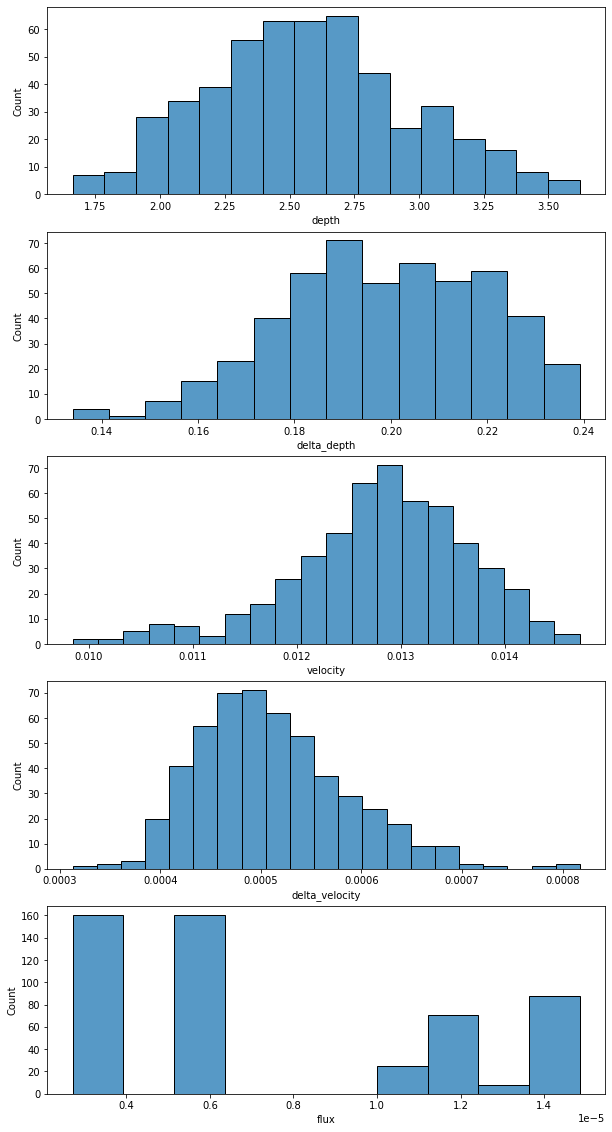

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [10]:
fig, axes = plt.subplots(nrows=len(in_cols),  figsize=(10,20))
for i in range(len(in_cols)):
    feature = in_cols[i]
    plt.figure(figsize = (5, 5))
    sns.histplot(x=data[feature].dropna(), ax=axes[i])

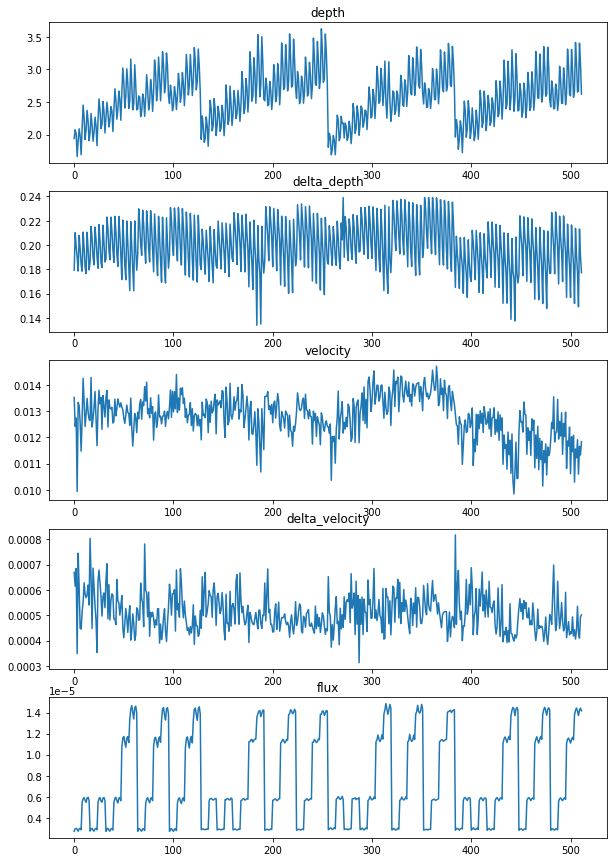

In [11]:
fig, ax = plt.subplots(len(in_cols), figsize=(10,15))
for i in range(len(in_cols)):
    ax[i].plot(data[in_cols[i]])
    ax[i].title.set_text(in_cols[i])

We can see that almost all the variables are continuous and evenly distributed. 
One remarkable visual inference from this is that Supernova Emergent Flux is surely showing some pattern, which might be attributed to either the types of supernovae being observed or the specific measurement techniques.

## Output Column Visualisation

Checking the distrubution and trends in the physical parameters here, 

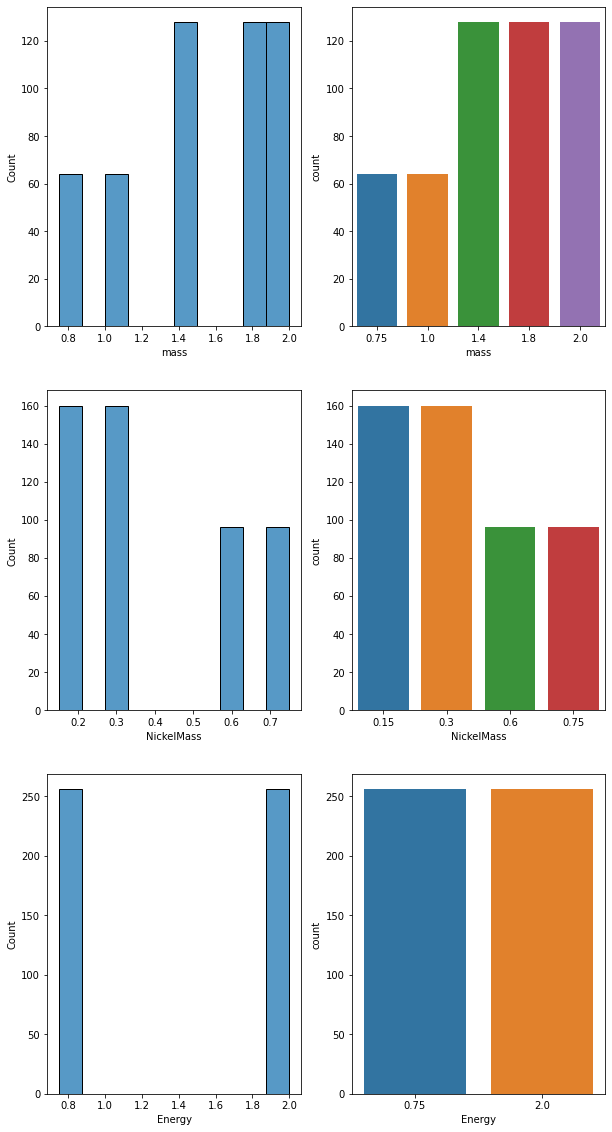

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [12]:
fig, axes = plt.subplots(nrows=len(out_numcols),ncols=2,figsize=(10,20))
for i in range(len(out_numcols)):
    feature = out_numcols[i]
    plt.figure(figsize = (5, 5))
    sns.histplot(x=data[feature].dropna(), ax=axes[i][0])
    sns.countplot(x=data[feature].dropna(), ax=axes[i][1])

*   We can conclude that the physical parameters in the dataset is fairly distributed which actually does indicate towards simulation. 
*   I have plotted the numerical parameters and we can see there are specifically some numerical values and that too very evenly distributed. Out of 512 instances, we can see distribution among output parameters



The distribution of these parameters calls for close inspection.

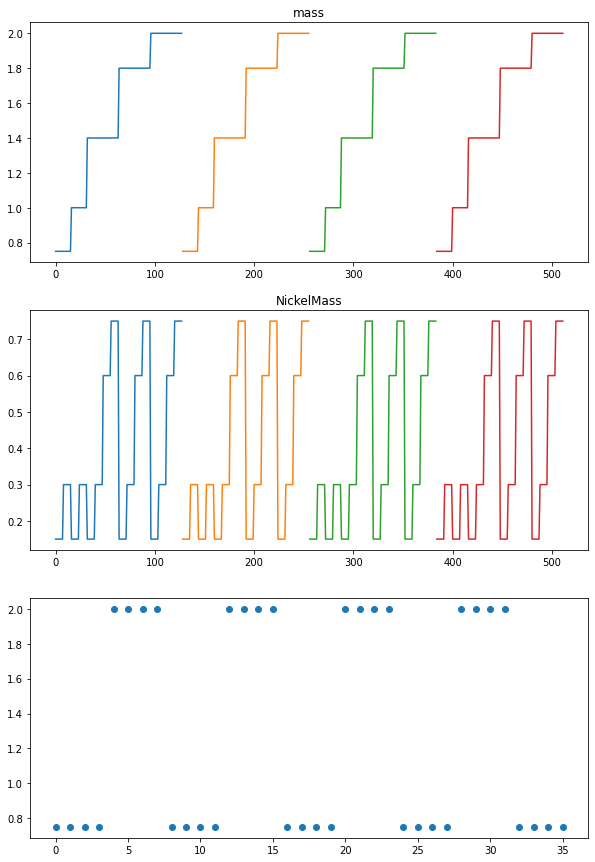

In [13]:
fig, ax = plt.subplots(len(out_numcols), figsize=(10,15))
plot_base=np.arange(512)
for i in range(len(out_numcols)):
    if(i<2):
        ax[i].plot(data[out_numcols[i]][0:128])
        ax[i].plot(data[out_numcols[i]][128:256])
        ax[i].plot(data[out_numcols[i]][256:384])
        ax[i].plot(data[out_numcols[i]][384:512])
        ax[i].title.set_text(out_numcols[i])
    if (i==2):
        ax[i]=plt.scatter(plot_base[0:36], data[out_numcols[i]][0:36])


These Plots show Mass and Nickel Mass show are very related trend and Explosion Energy have only two values 0.75 and 2.0 (units=10^51 ergs)

Plotting the countplot for Initial Parameters of the simulation.

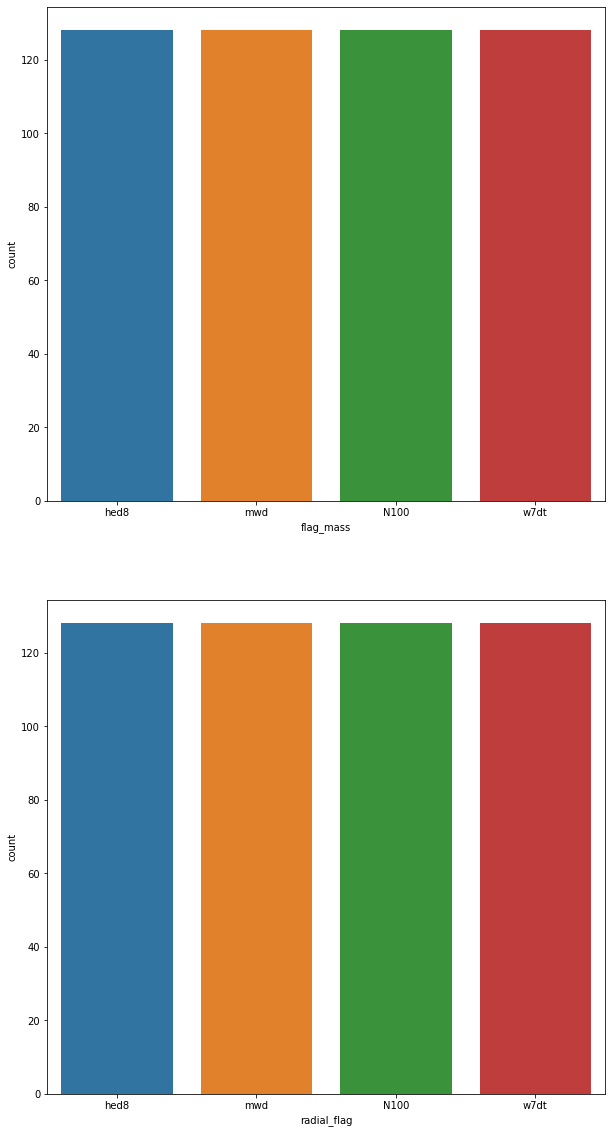

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [14]:
fig, axes = plt.subplots(nrows=len(out_txtcols),figsize=(10,20))
for i in range(len(out_txtcols)):
    feature = out_txtcols[i]
    plt.figure(figsize = (5, 5))
    sns.countplot(x=data[feature].dropna(), ax=axes[i])

We can see, initial parameters are of 4 kinds, which has been used to simulate the physical parameters.

## Feature Analysis

In [15]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_range= Q1-(1.5 * IQR)
upper_range= Q3+(1.5 * IQR)
print('Number of Outliers (Percentage):')
((data < (lower_range)) | (data > (upper_range))).sum()/len(data) * 100

Number of Outliers (Percentage):


Energy            0.000000
NickelMass        0.000000
delta_depth       0.390625
delta_velocity    0.976562
depth             0.195312
flag_mass         0.000000
flux              0.000000
mass              0.000000
radial_flag       0.000000
velocity          3.515625
dtype: float64

Now, we already know the data is very specific and streamlined. Plotting a correlation matrix can help us to understand dependancies.

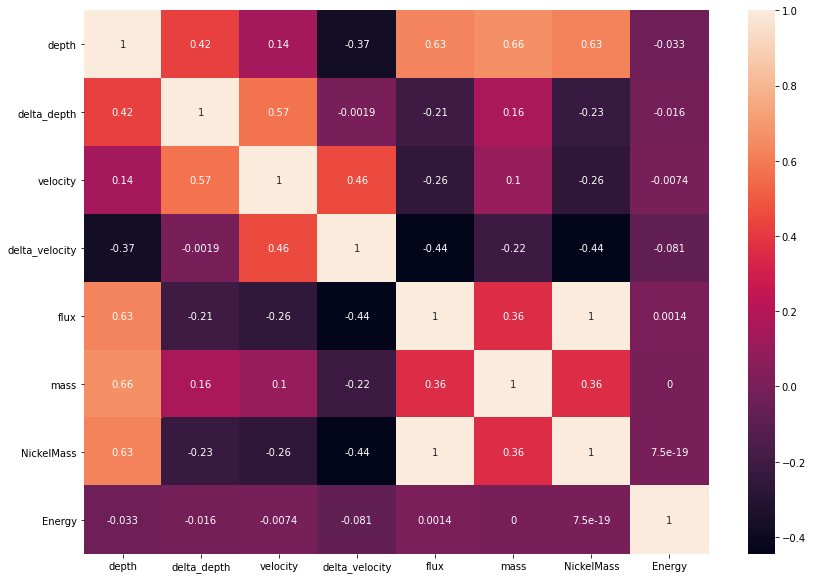

In [16]:
plt.figure(figsize = (14, 10))
corr_mat = data.corr()
sns.heatmap(corr_mat, xticklabels = corr_mat.columns, yticklabels = corr_mat.columns, annot=True)

One of the major takeaways from this is, we can ignore the co-dependencies of one physical parameters on other. 

Although Mass and Nickel Mass are still indeed quite evidently affecting each other. 

One of the major techniques to identify the trends of input and output variables is plotting Pairplots.

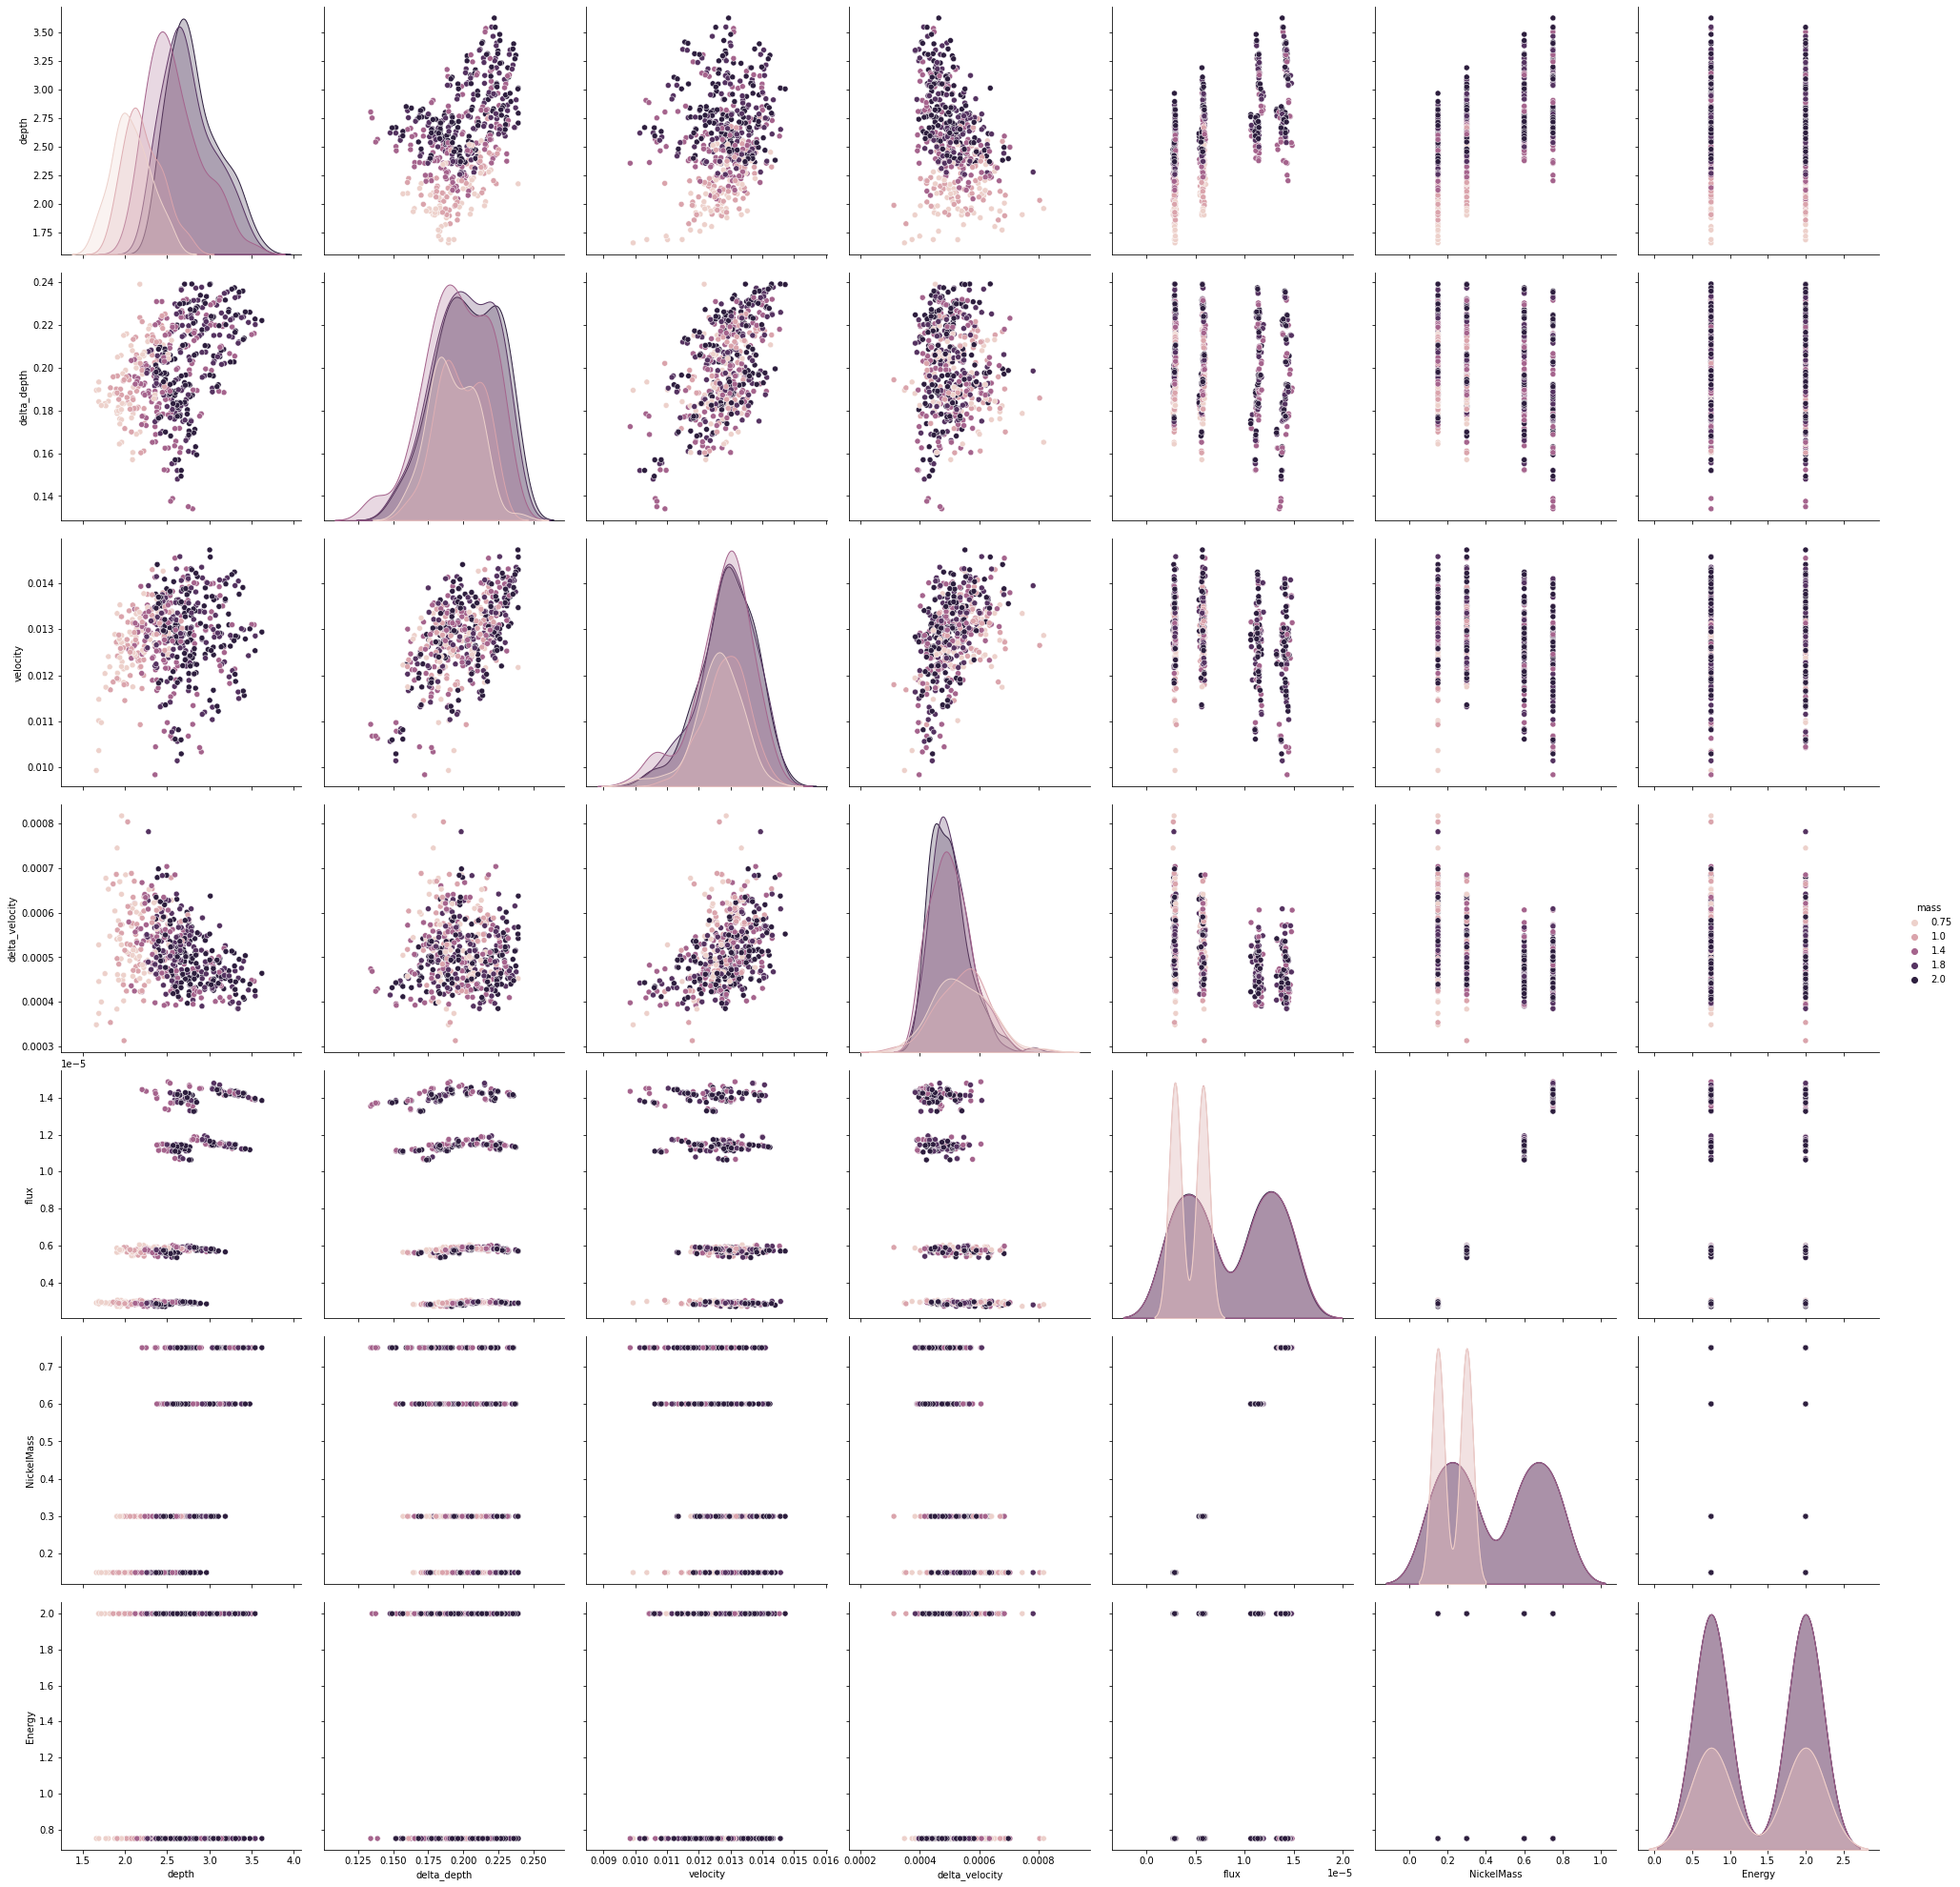

In [17]:
g = sns.pairplot(data,hue="mass",height=4)
plt.show()

To derive relationships of Physical Parameters to Observables, we can plot particular pairplots.

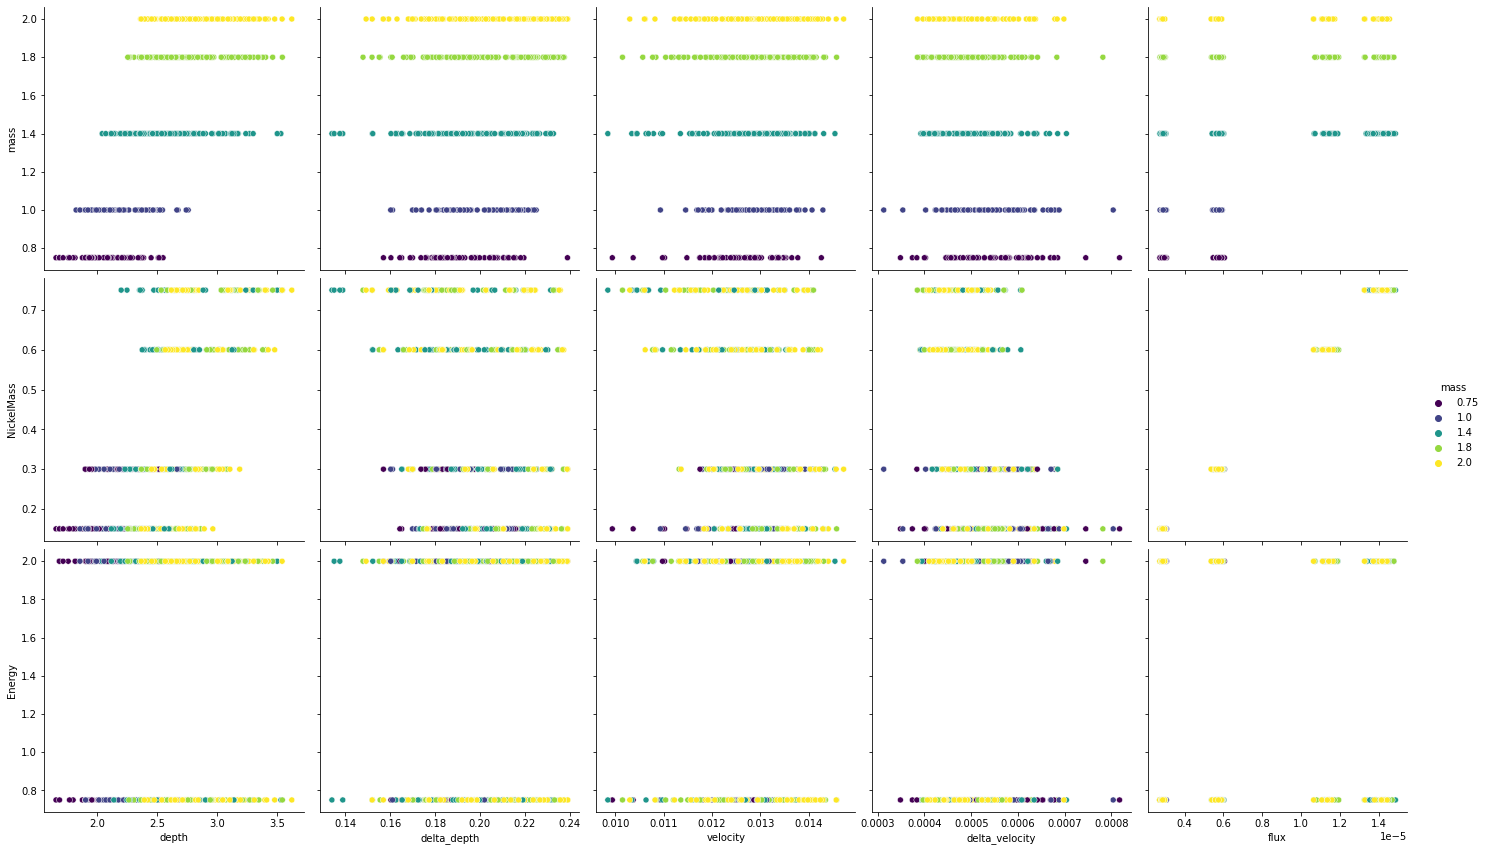

In [ ]:
g = sns.pairplot(data,hue="mass",palette='viridis',x_vars=["depth", "delta_depth", "velocity", "delta_velocity", "flux"],
    y_vars=["mass", "NickelMass","Energy"], height=4)
plt.show()

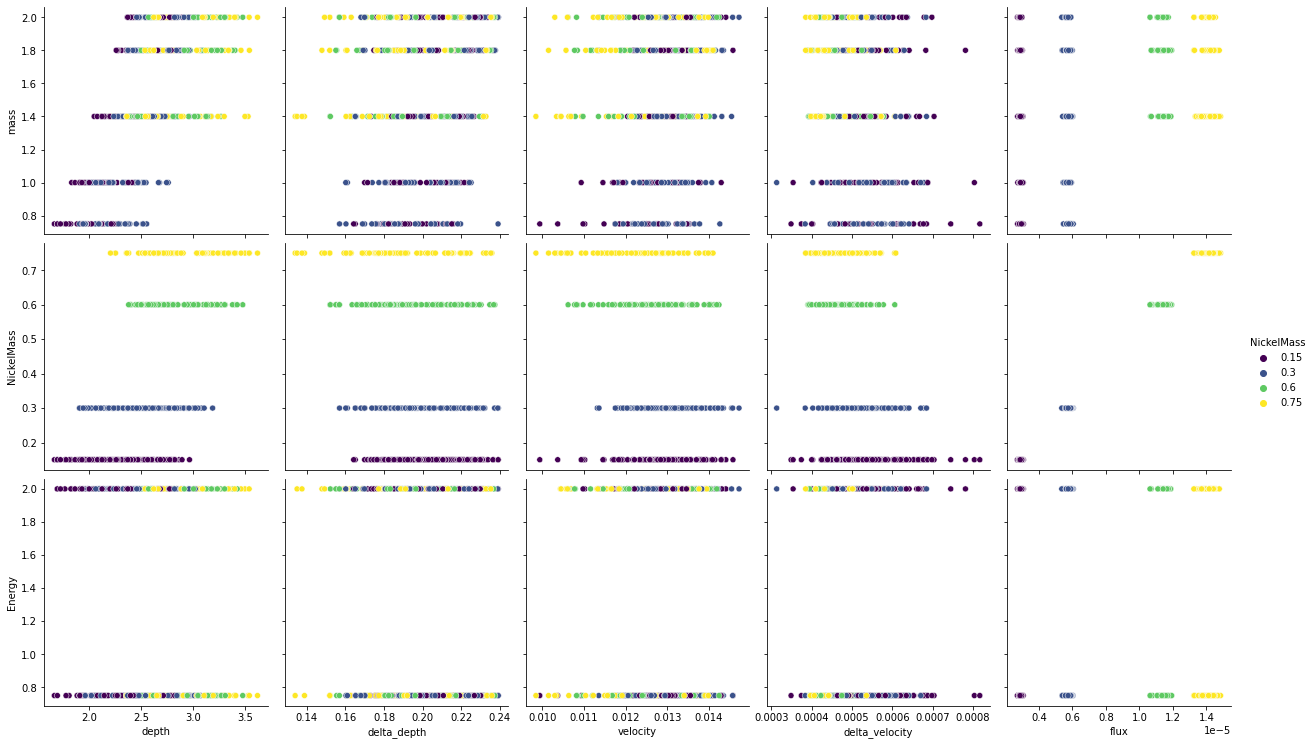

In [ ]:
g1 = sns.pairplot(data,hue="NickelMass",x_vars=["depth", "delta_depth", "velocity", "delta_velocity", "flux"],
    y_vars=["mass", "NickelMass","Energy"],palette='viridis',height=3.5)
plt.show()

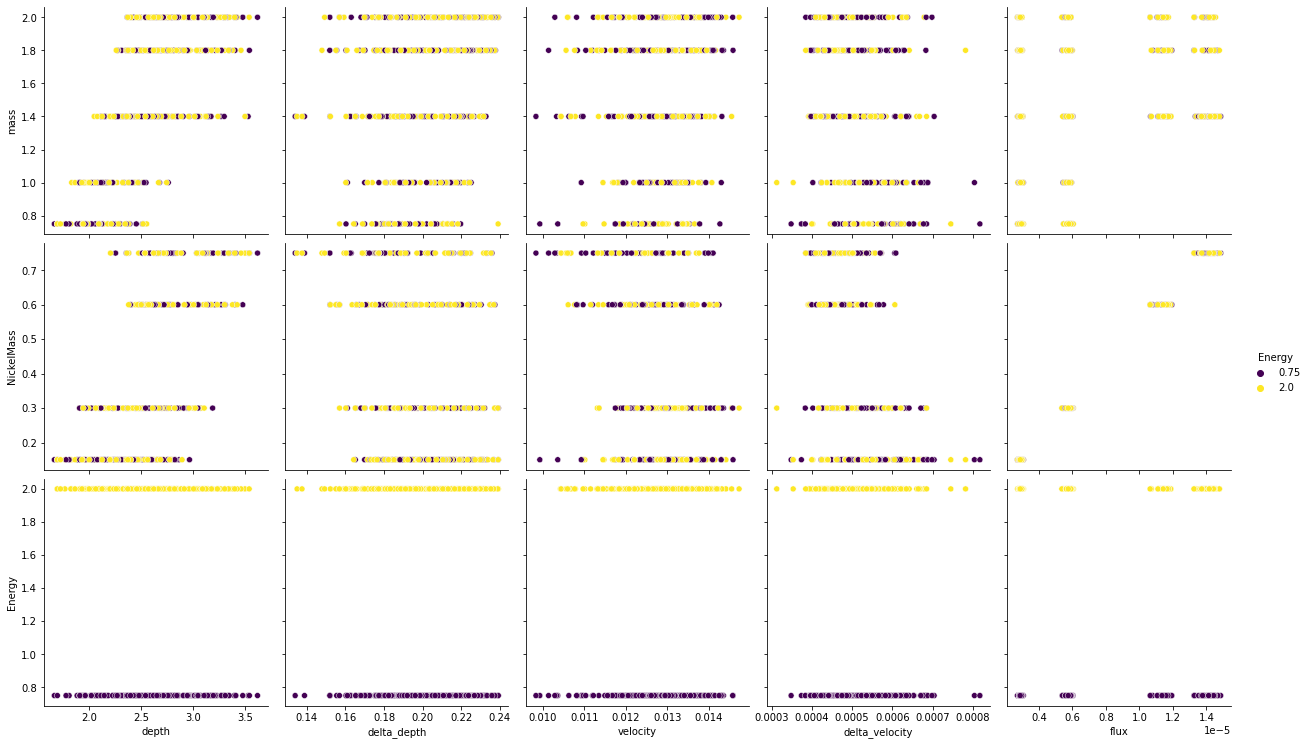

In [ ]:
g2 = sns.pairplot(data,hue="Energy",x_vars=["depth", "delta_depth", "velocity", "delta_velocity", "flux"],
    y_vars=["mass", "NickelMass","Energy"],palette='viridis', height=3.5)
plt.show()

What I will be employing for this particular task is two separate strategies:


1.   We can take advantage of independence of output features and apply separate models for each output parameters as a Regresssion Problem.
2.   We have also seen the Physical Parameters in this dataset is simulated and thus has some particular values only. We can do One-Hot Encoding and treat this as a classification problem. 


I will be applying the first approach, as that model will be more tolerant to real world physical parameter calculations, in my opinion. 

Now, since the number of Instances is only 512, we have to rely on ensemble learning as our primary weapon for predictions, all other models would be prone to bias due to small dataset and might not even understand the underlying patterns.



#Data Split

In [ ]:
dataset= dataset_raw.copy()

In [ ]:
num_cols= dataset.columns
num_colslen= len(dataset.columns)

In [ ]:
input_cols = num_cols[0:5]
print(input_cols)

Index(['depth', 'delta_depth', 'velocity', 'delta_velocity', 'flux'], dtype='object')


In [ ]:
output_cols = num_cols[5:]
print(output_cols)

Index(['mass', 'NickelMass', 'Energy', 'flag_mass', 'radial_flag'], dtype='object')


In [ ]:
categorical_cols = num_cols[8:]
print(categorical_cols)

Index(['flag_mass', 'radial_flag'], dtype='object')


## Normalise Pandas

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler

In [ ]:
dataMinMax= data.copy()

In [ ]:
autoscaler = MinMaxScaler()
dataMinMax[in_cols] = autoscaler.fit_transform(dataMinMax[in_cols])

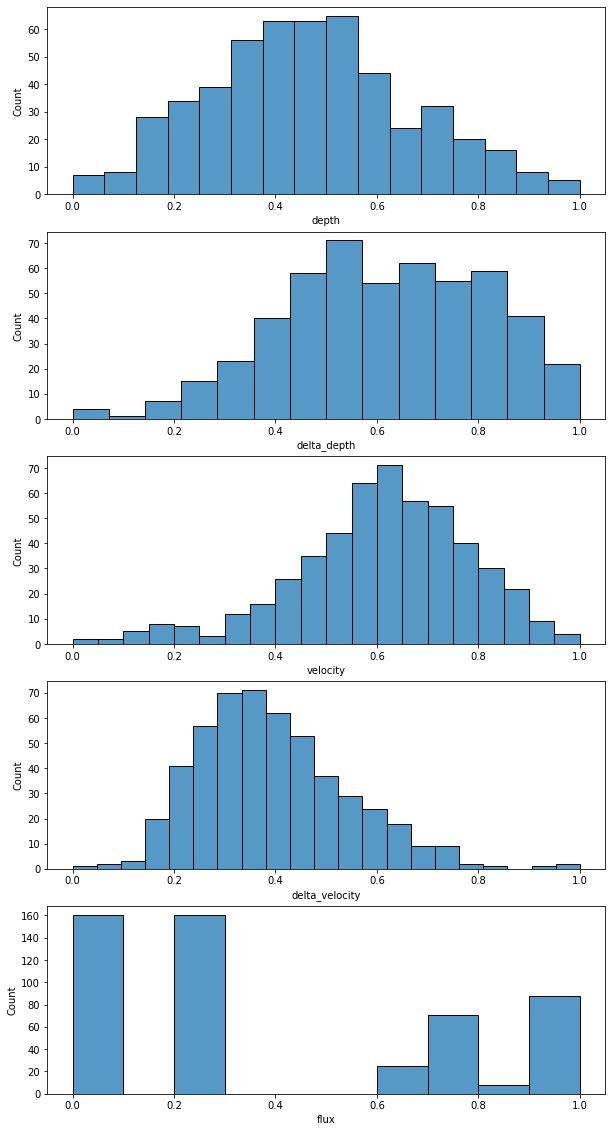

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(nrows=len(in_cols),  figsize=(10,20))
for i in range(len(in_cols)):
    feature = in_cols[i]
    plt.figure(figsize = (5, 5))
    sns.histplot(x=dataMinMax[feature].dropna(), ax=axes[i])

# Pandas to Tensors

In [ ]:
def dataframe_to_arrays(dataframe):
    dataframe1 = dataframe.copy(deep=True)
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [ ]:
inputs_array, targets_array = dataframe_to_arrays(dataset)
inputs_array, targets_array

(array([[1.94062823e+00, 1.79353979e-01, 1.35305729e-02, 6.69683082e-04,
         2.72379230e-06],
        [2.07199934e+00, 2.10287264e-01, 1.24227584e-02, 6.15043396e-04,
         2.97899987e-06],
        [2.00798154e+00, 1.98803979e-01, 1.27439797e-02, 6.84875169e-04,
         2.99240599e-06],
        ...,
        [3.40158781e+00, 2.13208728e-01, 1.16597757e-02, 4.09861955e-04,
         1.42339574e-05],
        [3.09122515e+00, 1.91139165e-01, 1.13293941e-02, 4.93807239e-04,
         1.44203394e-05],
        [2.62069172e+00, 1.77249252e-01, 1.18432571e-02, 5.01125787e-04,
         1.41695511e-05]]), array([[0.75, 0.15, 0.75, 1.  , 1.  ],
        [0.75, 0.15, 0.75, 1.  , 2.  ],
        [0.75, 0.15, 0.75, 1.  , 0.  ],
        ...,
        [2.  , 0.75, 2.  , 3.  , 2.  ],
        [2.  , 0.75, 2.  , 3.  , 0.  ],
        [2.  , 0.75, 2.  , 3.  , 3.  ]]))

In [ ]:
inputs = torch.tensor(inputs_array, dtype= torch.float32)
targets = torch.tensor(targets_array, dtype=torch.float32)

#Separate Single Variable Splits

In [ ]:
targets.size()

torch.Size([512, 5])

In [ ]:
mass=targets[:,0]
NiMass= targets[:,1]
Energy= targets[:,2]
massDist= targets[:,3]
radialDist= targets[:,4]

In [ ]:
#Changing Classification type tensors to long
massDistLong= massDist.type(torch.LongTensor)
radDistLong= radialDist.type(torch.LongTensor)

In [ ]:
datasetMass = TensorDataset(inputs, mass)
datasetNiM = TensorDataset(inputs, NiMass)
datasetNRG= TensorDataset(inputs, Energy)
datasetMassD= TensorDataset(inputs, massDistLong)
datasetRadD= TensorDataset(inputs, radDistLong)

#DataLoader batch split

In [ ]:
num_rows= len(dataset)

In [ ]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
origin_size = num_rows - val_size

train_dsMassO, val_dsMass = random_split(datasetMass,[origin_size,val_size]) 
train_dsNiMO, val_dsNiM = random_split(datasetNiM,[origin_size,val_size])
train_dsNRGO, val_dsNRG = random_split(datasetNRG,[origin_size,val_size])
train_dsMassDO, val_dsMassD = random_split(datasetMassD,[origin_size,val_size])
train_dsRadDO, val_dsRadD = random_split(datasetRadD,[origin_size,val_size])

In [ ]:
num_trainRows= len(train_dsMassO)
print(num_trainRows)

436


In [ ]:
test_percent = 0.11
test_size = int(num_trainRows*test_percent)
train_size= num_trainRows- test_size


train_dsMass, test_dsMass = random_split(train_dsMassO,[train_size,test_size]) 
train_dsNiM, test_dsNiM = random_split(train_dsNiMO,[train_size,test_size])
train_dsNRG, test_dsNRG = random_split(train_dsNRGO,[train_size,test_size])
train_dsMassD, test_dsMassD = random_split(train_dsMassDO,[train_size,test_size])
train_dsRadD, test_dsRadD = random_split(train_dsRadDO,[train_size,test_size])

In [ ]:
print(len(test_dsMass))

47


#Batch Assignment

In [ ]:
batch_size = 64

In [ ]:
train_loaderMass = DataLoader(train_dsMass, batch_size, shuffle=True)
val_loaderMass = DataLoader(val_dsMass, batch_size)
test_loaderMass = DataLoader(test_dsMass)

In [ ]:
train_loaderNiM = DataLoader(train_dsNiM, batch_size, shuffle=True)
val_loaderNiM = DataLoader(val_dsNiM, batch_size)
test_loaderNiM = DataLoader(test_dsNiM)

In [ ]:
train_loaderNRG = DataLoader(train_dsNRG, batch_size, shuffle=True)
val_loaderNRG = DataLoader(val_dsNRG, batch_size)
test_loaderNRG = DataLoader(test_dsNRG)

In [ ]:
train_loaderMassD = DataLoader(train_dsMassD, batch_size, shuffle=True)
val_loaderMassD = DataLoader(val_dsMassD, batch_size)
test_loaderMassD = DataLoader(test_dsMassD)

In [ ]:
train_loaderRadD = DataLoader(train_dsRadD, batch_size, shuffle=True)
val_loaderRadD = DataLoader(val_dsRadD, batch_size)
test_loaderRadD = DataLoader(test_dsRadD)

In [ ]:
for xb, yb in train_loaderMass:
    print("inputs:", xb)
    print("targets:", yb.unsqueeze(0))
    break

inputs: tensor([[3.0982e+00, 2.0515e-01, 1.2921e-02, 4.6294e-04, 1.1457e-05],
        [2.4420e+00, 1.9700e-01, 1.3502e-02, 5.5604e-04, 5.6120e-06],
        [2.4186e+00, 1.6923e-01, 1.1317e-02, 4.7774e-04, 5.6480e-06],
        [2.5119e+00, 1.8559e-01, 1.2154e-02, 4.7449e-04, 1.1448e-05],
        [3.3971e+00, 2.3586e-01, 1.3907e-02, 4.4757e-04, 1.4098e-05],
        [2.3520e+00, 1.9152e-01, 1.2695e-02, 5.6594e-04, 2.7404e-06],
        [3.3409e+00, 2.1146e-01, 1.1638e-02, 3.8472e-04, 1.4275e-05],
        [2.5117e+00, 1.9048e-01, 1.3143e-02, 6.0564e-04, 1.4851e-05],
        [2.3803e+00, 2.0349e-01, 1.3284e-02, 6.2698e-04, 5.9286e-06],
        [2.9385e+00, 2.3095e-01, 1.3506e-02, 5.4549e-04, 5.8256e-06],
        [2.5732e+00, 1.8218e-01, 1.2565e-02, 4.3399e-04, 5.6646e-06],
        [2.2232e+00, 2.0557e-01, 1.3775e-02, 4.7691e-04, 6.0209e-06],
        [2.4131e+00, 2.0973e-01, 1.3571e-02, 5.0223e-04, 2.9105e-06],
        [3.0710e+00, 2.1988e-01, 1.2918e-02, 4.0088e-04, 1.4465e-05],
        [2.4

After application of various other Regression Techniques. Two of the best performance was achieved by Stacking Regressor and Linar Regression Neural Network Model in PyTorch. 

The Advantage of Pytorch is that we get greater control of over model. 

And It would help us debug cases when there is overfitting of Data

# Model Class

In [ ]:
input_size = len(input_cols)
hidden_size= 3
output_size = 1

In [ ]:
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lossFn = torch.nn.MSELoss()
        #use input_size & output_size defined above
        # hidden layer
        self.linear1 = nn.Linear(input_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, xb):
        #xb = xb.squeeze(0)
        out = self.linear1(xb) 
        # Apply activation function
        out1 = F.relu(out)
        # Get predictions using output layer
        out1 = self.linear2(out1)                        
        return out1
    
    def training_step(self, batch):
        inputs, targets = batch 
        targets= targets.unsqueeze(-1)
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = self.lossFn(out,targets)                    
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        targets= targets.unsqueeze(-1)
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = self.lossFn(out,targets)                          
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 5== 0 or epoch == num_epochs-1:
            print("Epoch [{}],train_loss: {:.4f}, val_loss: {:.4f}".format(epoch+1,result['train_loss'], result['val_loss']))

#Model Init

In [ ]:
modelMass= RegressionModel()

In [ ]:
modelNiM= RegressionModel()
modelNRG= RegressionModel()

In [ ]:
list(modelMass.parameters())

[Parameter containing:
 tensor([[-0.3249,  0.0891, -0.0680,  0.1095, -0.2779],
         [ 0.3043,  0.1674, -0.3721, -0.1349, -0.4282],
         [ 0.3965,  0.2164,  0.0478, -0.4220,  0.3958]], requires_grad=True),
 Parameter containing:
 tensor([-0.4309, -0.1913,  0.0036], requires_grad=True),
 Parameter containing:
 tensor([[ 0.5191, -0.2996, -0.3373]], requires_grad=True),
 Parameter containing:
 tensor([0.3602], requires_grad=True)]

#Training Helper functions

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    train_losses = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

#Training and Propagation

## Mass

In [ ]:
result = evaluate(modelMass, val_loaderMass) # Use the the evaluate function
print(result)

{'val_loss': 1.3491020202636719}


In [ ]:
epochs = 64
lr = 1e-5
history1 = fit(epochs, lr, modelMass, train_loaderMass, val_loaderMass)

Epoch [5],train_loss: 1.2102, val_loss: 1.3463
Epoch [10],train_loss: 1.2157, val_loss: 1.3435
Epoch [15],train_loss: 1.2257, val_loss: 1.3407
Epoch [20],train_loss: 1.2194, val_loss: 1.3379
Epoch [25],train_loss: 1.2184, val_loss: 1.3351
Epoch [30],train_loss: 1.2143, val_loss: 1.3324
Epoch [35],train_loss: 1.2140, val_loss: 1.3296
Epoch [40],train_loss: 1.2158, val_loss: 1.3268
Epoch [45],train_loss: 1.2100, val_loss: 1.3241
Epoch [50],train_loss: 1.2061, val_loss: 1.3214
Epoch [55],train_loss: 1.2031, val_loss: 1.3187
Epoch [60],train_loss: 1.2027, val_loss: 1.3159
Epoch [64],train_loss: 1.2014, val_loss: 1.3137


In [ ]:
epochs = 64
lr = 1e-5
history1 += fit(epochs, lr, modelMass, train_loaderMass, val_loaderMass)

Epoch [5],train_loss: 1.1991, val_loss: 1.3110
Epoch [10],train_loss: 1.1906, val_loss: 1.3082
Epoch [15],train_loss: 1.1928, val_loss: 1.3055
Epoch [20],train_loss: 1.1974, val_loss: 1.3027
Epoch [25],train_loss: 1.1954, val_loss: 1.2999
Epoch [30],train_loss: 1.1957, val_loss: 1.2972
Epoch [35],train_loss: 1.1947, val_loss: 1.2944
Epoch [40],train_loss: 1.1905, val_loss: 1.2917
Epoch [45],train_loss: 1.1915, val_loss: 1.2890
Epoch [50],train_loss: 1.1903, val_loss: 1.2862
Epoch [55],train_loss: 1.1863, val_loss: 1.2836
Epoch [60],train_loss: 1.1839, val_loss: 1.2809
Epoch [64],train_loss: 1.1831, val_loss: 1.2787


In [ ]:
epochs = 64
lr = 1e-4
history1 += fit(epochs, lr, modelMass, train_loaderMass, val_loaderMass)

Epoch [5],train_loss: 1.1608, val_loss: 1.2519
Epoch [10],train_loss: 1.1454, val_loss: 1.2259
Epoch [15],train_loss: 1.1194, val_loss: 1.2016
Epoch [20],train_loss: 1.1010, val_loss: 1.1779
Epoch [25],train_loss: 1.0917, val_loss: 1.1541
Epoch [30],train_loss: 1.0781, val_loss: 1.1311
Epoch [35],train_loss: 1.0695, val_loss: 1.1080
Epoch [40],train_loss: 1.0591, val_loss: 1.0854
Epoch [45],train_loss: 1.0475, val_loss: 1.0634
Epoch [50],train_loss: 1.0359, val_loss: 1.0418
Epoch [55],train_loss: 1.0262, val_loss: 1.0201
Epoch [60],train_loss: 1.0163, val_loss: 0.9989
Epoch [64],train_loss: 1.0065, val_loss: 0.9826


In [ ]:
epochs = 64
lr = 1e-4
history1 += fit(epochs, lr, modelMass, train_loaderMass, val_loaderMass)

Epoch [5],train_loss: 0.8787, val_loss: 0.9620
Epoch [10],train_loss: 0.8620, val_loss: 0.9422
Epoch [15],train_loss: 0.8456, val_loss: 0.9229
Epoch [20],train_loss: 0.8409, val_loss: 0.9035
Epoch [25],train_loss: 0.8299, val_loss: 0.8849
Epoch [30],train_loss: 0.8235, val_loss: 0.8662
Epoch [35],train_loss: 0.8120, val_loss: 0.8483
Epoch [40],train_loss: 0.8013, val_loss: 0.8306
Epoch [45],train_loss: 0.7900, val_loss: 0.8135
Epoch [50],train_loss: 0.7810, val_loss: 0.7966
Epoch [55],train_loss: 0.7729, val_loss: 0.7798
Epoch [60],train_loss: 0.7667, val_loss: 0.7630
Epoch [64],train_loss: 0.7581, val_loss: 0.7506


In [ ]:
epochs = 100
lr = 1e-4
history1 += fit(epochs, lr, modelMass, train_loaderMass, val_loaderMass)

Epoch [5],train_loss: 0.6527, val_loss: 0.7347
Epoch [10],train_loss: 0.6437, val_loss: 0.7191
Epoch [15],train_loss: 0.6299, val_loss: 0.7042
Epoch [20],train_loss: 0.6223, val_loss: 0.6894
Epoch [25],train_loss: 0.6184, val_loss: 0.6747
Epoch [30],train_loss: 0.6091, val_loss: 0.6607
Epoch [35],train_loss: 0.6057, val_loss: 0.6464
Epoch [40],train_loss: 0.6015, val_loss: 0.6324
Epoch [45],train_loss: 0.5926, val_loss: 0.6193
Epoch [50],train_loss: 0.5898, val_loss: 0.6056
Epoch [55],train_loss: 0.5849, val_loss: 0.5925
Epoch [60],train_loss: 0.5770, val_loss: 0.5803
Epoch [65],train_loss: 0.5713, val_loss: 0.5679
Epoch [70],train_loss: 0.5660, val_loss: 0.5558
Epoch [75],train_loss: 0.5611, val_loss: 0.5439
Epoch [80],train_loss: 0.5552, val_loss: 0.5324
Epoch [85],train_loss: 0.5490, val_loss: 0.5213
Epoch [90],train_loss: 0.5442, val_loss: 0.5100
Epoch [95],train_loss: 0.5388, val_loss: 0.4991
Epoch [100],train_loss: 0.5338, val_loss: 0.4884


In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

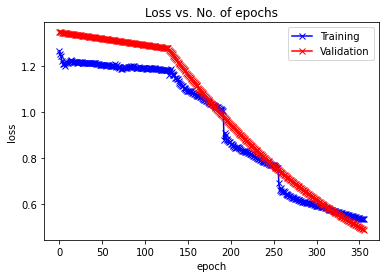

In [ ]:
plot_losses(history1)

###Testing Mass Values

In [ ]:
test1=torch.FloatTensor([3.35,0,0.015,0,1.20e-5])

In [ ]:
yb= modelMass(test1)
print(yb)

tensor([1.4992], grad_fn=<AddBackward0>)


In [ ]:
test2= torch.FloatTensor([2.54,0,0.013,0,5.02e-6])
test3= torch.FloatTensor([2.46,0,0.013,0, 1.03e-5])

In [ ]:
yb2= modelMass(test2)
yb3= modelMass(test3)
print(yb2)

tensor([1.3353], grad_fn=<AddBackward0>)


In [ ]:
resultTest= evaluate(modelMass, test_loaderMass) # Use the the evaluate function
print(resultTest)

{'val_loss': 0.45065149664878845}


## Nickel Mass

In [ ]:
resultNiM = evaluate(modelNiM, val_loaderNiM) # Use the the evaluate function
print(resultNiM)

{'val_loss': 0.0711221694946289}


In [ ]:
epochs = 50
lr = 1e-6
history1 += fit(epochs, lr, modelNiM, train_loaderNiM, val_loaderNiM)

Epoch [5],train_loss: 0.0728, val_loss: 0.0711
Epoch [10],train_loss: 0.0728, val_loss: 0.0711
Epoch [15],train_loss: 0.0717, val_loss: 0.0710
Epoch [20],train_loss: 0.0722, val_loss: 0.0710
Epoch [25],train_loss: 0.0719, val_loss: 0.0710
Epoch [30],train_loss: 0.0721, val_loss: 0.0710
Epoch [35],train_loss: 0.0724, val_loss: 0.0709
Epoch [40],train_loss: 0.0725, val_loss: 0.0709
Epoch [45],train_loss: 0.0722, val_loss: 0.0709
Epoch [50],train_loss: 0.0720, val_loss: 0.0709


In [ ]:
epochs = 50
lr = 1e-4
history1 += fit(epochs, lr, modelNiM, train_loaderNiM, val_loaderNiM)

Epoch [5],train_loss: 0.0723, val_loss: 0.0684
Epoch [10],train_loss: 0.0702, val_loss: 0.0662
Epoch [15],train_loss: 0.0684, val_loss: 0.0643
Epoch [20],train_loss: 0.0677, val_loss: 0.0624
Epoch [25],train_loss: 0.0669, val_loss: 0.0607
Epoch [30],train_loss: 0.0657, val_loss: 0.0591
Epoch [35],train_loss: 0.0648, val_loss: 0.0575
Epoch [40],train_loss: 0.0640, val_loss: 0.0561
Epoch [45],train_loss: 0.0631, val_loss: 0.0549
Epoch [50],train_loss: 0.0624, val_loss: 0.0538


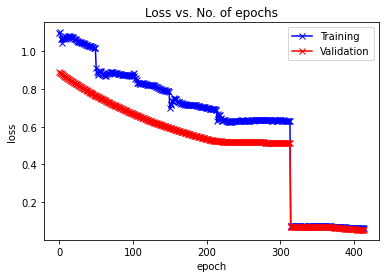

In [ ]:
plot_losses(history1)

### Testing Nickel Mass Values

In [ ]:
yb11= modelNiM(test1)
yb22= modelNiM(test2)
yb33= modelNiM(test3)
print(yb11,yb22,yb33)

tensor([0.6285], grad_fn=<AddBackward0>) tensor([0.4792], grad_fn=<AddBackward0>) tensor([0.4644], grad_fn=<AddBackward0>)


In [ ]:
resultTestNiM= evaluate(modelNiM, test_loaderNiM) # Use the the evaluate function
print(resultTestNiM)

{'val_loss': 0.04941482096910477}


## Energy

In [ ]:
result = evaluate(modelNRG, val_loaderNRG) # Use the the evaluate function
print(result)

{'val_loss': 2.8941516876220703}


In [ ]:
epochs = 50
lr = 1e-4
history1 = fit(epochs, lr, modelNRG, train_loaderNRG, val_loaderNRG)

Epoch [5],train_loss: 3.4180, val_loss: 2.8243
Epoch [10],train_loss: 3.2809, val_loss: 2.7591
Epoch [15],train_loss: 3.2336, val_loss: 2.6951
Epoch [20],train_loss: 3.1927, val_loss: 2.6331
Epoch [25],train_loss: 3.1548, val_loss: 2.5727
Epoch [30],train_loss: 3.1186, val_loss: 2.5137
Epoch [35],train_loss: 3.0838, val_loss: 2.4564
Epoch [40],train_loss: 3.0676, val_loss: 2.3985
Epoch [45],train_loss: 3.0411, val_loss: 2.3425
Epoch [50],train_loss: 3.0098, val_loss: 2.2883


In [ ]:
epochs = 50
lr = 1e-4
history1 += fit(epochs, lr, modelNRG, train_loaderNRG, val_loaderNRG)

Epoch [5],train_loss: 2.6680, val_loss: 2.2349
Epoch [10],train_loss: 2.6576, val_loss: 2.1819
Epoch [15],train_loss: 2.6342, val_loss: 2.1296
Epoch [20],train_loss: 2.5891, val_loss: 2.0792
Epoch [25],train_loss: 2.5693, val_loss: 2.0282
Epoch [30],train_loss: 2.5412, val_loss: 1.9788
Epoch [35],train_loss: 2.5053, val_loss: 1.9306
Epoch [40],train_loss: 2.4784, val_loss: 1.8823
Epoch [45],train_loss: 2.4437, val_loss: 1.8356
Epoch [50],train_loss: 2.4180, val_loss: 1.7886


In [ ]:
epochs = 50
lr = 1e-4
history1 += fit(epochs, lr, modelNRG, train_loaderNRG, val_loaderNRG)

Epoch [5],train_loss: 2.0805, val_loss: 1.7429
Epoch [10],train_loss: 2.0872, val_loss: 1.6966
Epoch [15],train_loss: 2.0790, val_loss: 1.6509
Epoch [20],train_loss: 2.0491, val_loss: 1.6063
Epoch [25],train_loss: 2.0243, val_loss: 1.5621
Epoch [30],train_loss: 1.9963, val_loss: 1.5186
Epoch [35],train_loss: 1.9696, val_loss: 1.4758
Epoch [40],train_loss: 1.9356, val_loss: 1.4344
Epoch [45],train_loss: 1.9126, val_loss: 1.3926
Epoch [50],train_loss: 1.8869, val_loss: 1.3519


In [ ]:
epochs = 64
lr = 1e-4
history1 += fit(epochs, lr, modelNRG, train_loaderNRG, val_loaderNRG)

Epoch [5],train_loss: 1.6222, val_loss: 1.3117
Epoch [10],train_loss: 1.5775, val_loss: 1.2728
Epoch [15],train_loss: 1.5720, val_loss: 1.2335
Epoch [20],train_loss: 1.5501, val_loss: 1.1953
Epoch [25],train_loss: 1.5288, val_loss: 1.1580
Epoch [30],train_loss: 1.5111, val_loss: 1.1209
Epoch [35],train_loss: 1.4882, val_loss: 1.0851
Epoch [40],train_loss: 1.4620, val_loss: 1.0509
Epoch [45],train_loss: 1.4382, val_loss: 1.0172
Epoch [50],train_loss: 1.4147, val_loss: 0.9849
Epoch [55],train_loss: 1.3899, val_loss: 0.9538
Epoch [60],train_loss: 1.3673, val_loss: 0.9234
Epoch [64],train_loss: 1.3508, val_loss: 0.8997


In [ ]:
epochs = 100
lr = 1e-5
history1 += fit(epochs, lr, modelNRG, train_loaderNRG, val_loaderNRG)

Epoch [5],train_loss: 1.0958, val_loss: 0.8967
Epoch [10],train_loss: 1.1191, val_loss: 0.8936
Epoch [15],train_loss: 1.1040, val_loss: 0.8907
Epoch [20],train_loss: 1.0954, val_loss: 0.8878
Epoch [25],train_loss: 1.0947, val_loss: 0.8849
Epoch [30],train_loss: 1.0997, val_loss: 0.8819
Epoch [35],train_loss: 1.0973, val_loss: 0.8790
Epoch [40],train_loss: 1.0950, val_loss: 0.8761
Epoch [45],train_loss: 1.0924, val_loss: 0.8731
Epoch [50],train_loss: 1.0921, val_loss: 0.8702
Epoch [55],train_loss: 1.0948, val_loss: 0.8672
Epoch [60],train_loss: 1.0916, val_loss: 0.8643
Epoch [65],train_loss: 1.0903, val_loss: 0.8615
Epoch [70],train_loss: 1.0914, val_loss: 0.8585
Epoch [75],train_loss: 1.0936, val_loss: 0.8555
Epoch [80],train_loss: 1.0920, val_loss: 0.8527
Epoch [85],train_loss: 1.0915, val_loss: 0.8498
Epoch [90],train_loss: 1.0907, val_loss: 0.8469
Epoch [95],train_loss: 1.0904, val_loss: 0.8440
Epoch [100],train_loss: 1.0878, val_loss: 0.8412


### Testing Energy Values

In [ ]:
resultTestNRG= evaluate(modelNRG, test_loaderNRG) # Use the the evaluate function
print(resultTestNRG)

{'val_loss': 1.070089340209961}


In [ ]:
yb11= modelNRG(test1)
yb22= modelNRG(test2)
yb33= modelNRG(test3)
print(yb11,yb22,yb33)

tensor([0.6853], grad_fn=<AddBackward0>) tensor([0.5439], grad_fn=<AddBackward0>) tensor([0.5299], grad_fn=<AddBackward0>)


We have achieved fairly good results for the 3 Numeric Outputs, we are required to predict.

Keeping in mind the dataset is very small for now. I have ignored use of some of the training techniques especially the use of Weight Decay and Gradient Clipping which helps to punish outliers in model. 

Now with these results in mind, we can proceed to attempt Pytorch Classification Models on last two columns which are basically categorical in nature for Inital Parameters



#Classification of Last 2 Columns

## Pytorch Classification Linear Networks

###Model Class

#### Training Helper and Accuracy for Classification

In [ ]:
def accuracy(outputs, targets):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == targets).item() / len(preds))

In [ ]:
class ClassificationModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        #xb = xb.squeeze(0)
        out = self.linear1(xb) 
        # Apply activation function
        out1 = F.relu(out)
        # Get predictions using output layer
        #out1 = self.linear2(out1)                        
        return out1
    
    def training_step(self, batch):
        inputs, targets = batch 
        #targets= targets.unsqueeze(-1)
        out = self(inputs)                  # Generate predictions
        loss = F.cross_entropy(out, targets) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                    # Generate predictions
        loss = F.cross_entropy(out, targets)   # Calculate loss
        acc = accuracy(out, targets)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.6f}, val_acc: {:.6f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def evaluateC(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fitC(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

###Model Init

In [ ]:
modelMassD= ClassificationModel(input_size,4, 4)
modelRadD= ClassificationModel(input_size,4, 4)

### Mass Distribution
4 Categories

#### Training 

In [ ]:
history = [evaluateC(modelMassD, val_loaderMassD)]
history

[{'val_acc': 0.2578125, 'val_loss': 1.3661439418792725}]

In [ ]:
history += fitC(5, 0.5, modelMassD, train_loaderMassD, val_loaderMassD)

Epoch [0], val_loss: 1.381647, val_acc: 0.273438
Epoch [1], val_loss: 1.379060, val_acc: 0.273438
Epoch [2], val_loss: 1.393564, val_acc: 0.273438
Epoch [3], val_loss: 1.388046, val_acc: 0.239583
Epoch [4], val_loss: 1.398971, val_acc: 0.231771


In [ ]:
history += fitC(50, 0.005, modelMassD, train_loaderMassD, val_loaderMassD)

Epoch [0], val_loss: 1.398618, val_acc: 0.231771
Epoch [1], val_loss: 1.398407, val_acc: 0.231771
Epoch [2], val_loss: 1.398075, val_acc: 0.231771
Epoch [3], val_loss: 1.397870, val_acc: 0.231771
Epoch [4], val_loss: 1.397622, val_acc: 0.239583
Epoch [5], val_loss: 1.397298, val_acc: 0.239583
Epoch [6], val_loss: 1.396343, val_acc: 0.239583
Epoch [7], val_loss: 1.395765, val_acc: 0.239583
Epoch [8], val_loss: 1.395105, val_acc: 0.239583
Epoch [9], val_loss: 1.394091, val_acc: 0.247396
Epoch [10], val_loss: 1.393026, val_acc: 0.247396
Epoch [11], val_loss: 1.391698, val_acc: 0.247396
Epoch [12], val_loss: 1.390309, val_acc: 0.247396
Epoch [13], val_loss: 1.389160, val_acc: 0.247396
Epoch [14], val_loss: 1.388451, val_acc: 0.247396
Epoch [15], val_loss: 1.387759, val_acc: 0.239583
Epoch [16], val_loss: 1.386977, val_acc: 0.239583
Epoch [17], val_loss: 1.386498, val_acc: 0.239583
Epoch [18], val_loss: 1.386004, val_acc: 0.239583
Epoch [19], val_loss: 1.385679, val_acc: 0.247396
Epoch [20]

In [ ]:
history += fitC(50, 0.0005, modelMassD, train_loaderMassD, val_loaderMassD)

Epoch [0], val_loss: 1.382286, val_acc: 0.236979
Epoch [1], val_loss: 1.382303, val_acc: 0.236979
Epoch [2], val_loss: 1.382295, val_acc: 0.236979
Epoch [3], val_loss: 1.382270, val_acc: 0.236979
Epoch [4], val_loss: 1.382246, val_acc: 0.236979
Epoch [5], val_loss: 1.382253, val_acc: 0.236979
Epoch [6], val_loss: 1.382246, val_acc: 0.236979
Epoch [7], val_loss: 1.382243, val_acc: 0.236979
Epoch [8], val_loss: 1.382231, val_acc: 0.236979
Epoch [9], val_loss: 1.382219, val_acc: 0.236979
Epoch [10], val_loss: 1.382184, val_acc: 0.236979
Epoch [11], val_loss: 1.382196, val_acc: 0.236979
Epoch [12], val_loss: 1.382225, val_acc: 0.236979
Epoch [13], val_loss: 1.382219, val_acc: 0.236979
Epoch [14], val_loss: 1.382220, val_acc: 0.236979
Epoch [15], val_loss: 1.382204, val_acc: 0.236979
Epoch [16], val_loss: 1.382188, val_acc: 0.236979
Epoch [17], val_loss: 1.382181, val_acc: 0.236979
Epoch [18], val_loss: 1.382190, val_acc: 0.236979
Epoch [19], val_loss: 1.382174, val_acc: 0.236979
Epoch [20]

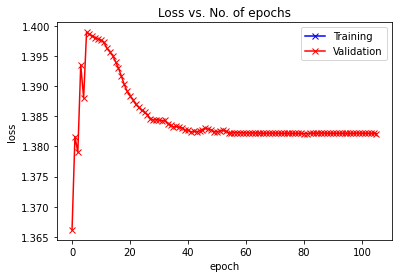

In [ ]:
plot_losses(history)

## ML Classifier Algorithms

It is visible the loss is getting saturated in Linear and Neural Network Models.

I also employed Decision Tree, Random Forest Models for classification, KNeighbours, etc for classification. Again the best results are obtained for Ensemble

Best Result is obtained in classification with Ensemble Learning. Applying AdaBoost, Stacking and Voting Classifiers performed better.

But Here I am mentioning the best results in terms of performance on a custom test set already separated.

A further probe can be undertaken for better Neural Networks

In [18]:
#Import Dependancies
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression,RidgeClassifier
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier, RandomForestRegressor,VotingRegressor, StackingRegressor
ExtraTreeRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, plot_confusion_matrix

In [ ]:
physical_parameters=['mass', 'NickelMass','Energy','flag_mass','radial_flag']
dataMinMax1= dataMinMax.copy()

### Mass Distribution

In [ ]:
x4MinMax= dataMinMax1[dataMinMax.columns[0:5]]
y4MinMax=dataMinMax1['flag_mass']
print(x4MinMax, y4MinMax)

        depth  delta_depth  velocity  delta_velocity      flux
0    0.142363     0.431324  0.755655        0.707497  0.000634
1    0.209375     0.725450  0.528722        0.599164  0.021665
2    0.176720     0.616263  0.594523        0.737618  0.022770
3    0.000000     0.527186  0.019050        0.070766  0.016735
4    0.125552     0.424219  0.717182        0.856801  0.001273
..        ...          ...       ...             ...       ...
507  0.504889     0.412314  0.424437        0.441792  0.940444
508  0.511846     0.144978  0.155339        0.235772  0.906408
509  0.887588     0.753229  0.372427        0.192355  0.949171
510  0.729274     0.543382  0.304749        0.358791  0.964530
511  0.489259     0.411311  0.410012        0.373302  0.943863

[512 rows x 5 columns] 0      hed8
1      hed8
2      hed8
3      hed8
4      hed8
       ... 
507    w7dt
508    w7dt
509    w7dt
510    w7dt
511    w7dt
Name: flag_mass, Length: 512, dtype: object


In [ ]:
x_train4MinMax, x_test4MinMax, y_train4MinMax, y_test4MinMax = train_test_split(x4MinMax, y4MinMax, test_size=0.2, random_state=42)
x_val4MinMax, x_test4MinMax, y_val4MinMax, y_test4MinMax = train_test_split(x_test4MinMax, y_test4MinMax, test_size=0.5, random_state=42)
print(x_train4MinMax.shape)
print(x_val4MinMax.shape)
print(x_test4MinMax.shape)
print(y_train4MinMax.shape)
print(y_val4MinMax.shape)
print(y_test4MinMax.shape)

(409, 5)
(51, 5)
(52, 5)
(409,)
(51,)
(52,)


In [ ]:
dtflagmass= DecisionTreeClassifier(max_depth=4)
dtflagmass.fit(x_train4MinMax, y_train4MinMax)
y_pred4MinMax = dtflagmass.predict(x_val4MinMax)
print(classification_report(y_pred4MinMax,y_val4MinMax))

              precision    recall  f1-score   support

        N100       0.67      0.55      0.60        11
        hed8       0.50      0.73      0.59        11
         mwd       0.61      0.58      0.59        19
        w7dt       0.75      0.60      0.67        10

    accuracy                           0.61        51
   macro avg       0.63      0.61      0.61        51
weighted avg       0.63      0.61      0.61        51



In [ ]:
randomflagmass= RandomForestClassifier(max_depth=30)
randomflagmass.fit(x_train4MinMax, y_train4MinMax)
y_pred4MinMax = randomflagmass.predict(x_val4MinMax)
print(classification_report(y_pred4MinMax,y_val4MinMax))

              precision    recall  f1-score   support

        N100       0.78      0.64      0.70        11
        hed8       0.81      0.87      0.84        15
         mwd       0.61      0.79      0.69        14
        w7dt       0.75      0.55      0.63        11

    accuracy                           0.73        51
   macro avg       0.74      0.71      0.71        51
weighted avg       0.74      0.73      0.72        51



In [ ]:
y_testing= randomflagmass.predict(x_test4MinMax)
print(classification_report(y_testing,y_test4MinMax))

              precision    recall  f1-score   support

        N100       0.77      0.62      0.69        16
        hed8       0.46      0.67      0.55         9
         mwd       0.67      0.67      0.67        12
        w7dt       0.86      0.80      0.83        15

    accuracy                           0.69        52
   macro avg       0.69      0.69      0.68        52
weighted avg       0.72      0.69      0.70        52



Although Classification is still not very good, but we can see a considerable improvement from Neural Network or Linear Regression type models.

Thus I would be using Stacking Classifier with base estimator as our Random Forest Classifier

0.7450980392156863
              precision    recall  f1-score   support

        N100       0.75      0.67      0.71         9
        hed8       0.93      0.88      0.90        16
         mwd       0.77      0.56      0.65        18
        w7dt       0.53      1.00      0.70         8

    accuracy                           0.75        51
   macro avg       0.75      0.77      0.74        51
weighted avg       0.78      0.75      0.74        51



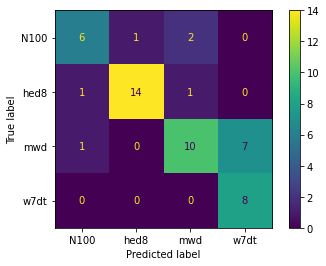

In [ ]:
est = RandomForestClassifier()

estimators = [('lr',LogisticRegression()),
              ('rc',RidgeClassifier()),
              ('et',ExtraTreeClassifier()),
              ('dt',DecisionTreeClassifier()),
              ('rf',RandomForestClassifier()),
              ('ab',AdaBoostClassifier()),
              ('bc',BaggingClassifier())]
stack4 = StackingClassifier(estimators=estimators, final_estimator=est)
stack4.fit(x_train4MinMax, y_train4MinMax)
y_pred4MinMax = stack4.predict(x_val4MinMax)
print(accuracy_score(y_val4MinMax, y_pred4MinMax))
print(classification_report(y_val4MinMax, y_pred4MinMax))

# Plot the confusion matrix using the provided functions.
plot_confusion_matrix(stack4, x_val4MinMax, y_val4MinMax)  
plt.show()  

###Final Test of Mass Distribution Parameters

In [ ]:
y_testing= stack4.predict(x_test4MinMax)
print(classification_report(y_testing,y_test4MinMax))

              precision    recall  f1-score   support

        N100       0.77      0.67      0.71        15
        hed8       0.62      0.67      0.64        12
         mwd       0.67      0.73      0.70        11
        w7dt       0.86      0.86      0.86        14

    accuracy                           0.73        52
   macro avg       0.73      0.73      0.73        52
weighted avg       0.74      0.73      0.73        52



In [ ]:
y_test111= stack4.predict(test1.reshape(-1,5))
y_test222= stack4.predict(test2.reshape(-1,5))
y_test333= stack4.predict(test3.reshape(-1,5))
print(y_test111,y_test222,y_test333)

['w7dt'] ['w7dt'] ['w7dt']


### Radial Ni Distribution

In [ ]:
x5MinMax= dataMinMax1[dataMinMax.columns[0:5]]
y5MinMax=dataMinMax1['radial_flag']
print(x5MinMax, y5MinMax)

        depth  delta_depth  velocity  delta_velocity      flux
0    0.142363     0.431324  0.755655        0.707497  0.000634
1    0.209375     0.725450  0.528722        0.599164  0.021665
2    0.176720     0.616263  0.594523        0.737618  0.022770
3    0.000000     0.527186  0.019050        0.070766  0.016735
4    0.125552     0.424219  0.717182        0.856801  0.001273
..        ...          ...       ...             ...       ...
507  0.504889     0.412314  0.424437        0.441792  0.940444
508  0.511846     0.144978  0.155339        0.235772  0.906408
509  0.887588     0.753229  0.372427        0.192355  0.949171
510  0.729274     0.543382  0.304749        0.358791  0.964530
511  0.489259     0.411311  0.410012        0.373302  0.943863

[512 rows x 5 columns] 0      hed8
1       mwd
2      N100
3      w7dt
4      hed8
       ... 
507    w7dt
508    hed8
509     mwd
510    N100
511    w7dt
Name: radial_flag, Length: 512, dtype: object


In [ ]:
x_train5MinMax, x_test5MinMax, y_train5MinMax, y_test5MinMax = train_test_split(x5MinMax, y5MinMax, test_size=0.2, random_state=42)
x_val5MinMax, x_test5MinMax, y_val5MinMax, y_test5MinMax = train_test_split(x_test5MinMax, y_test5MinMax, test_size=0.5, random_state=42)
print(x_train5MinMax.shape)
print(x_val5MinMax.shape)
print(x_test5MinMax.shape)
print(y_train5MinMax.shape)
print(y_val5MinMax.shape)
print(y_test5MinMax.shape)

(409, 5)
(51, 5)
(52, 5)
(409,)
(51,)
(52,)


In [ ]:
randomflagrad= RandomForestClassifier(max_depth=11)
randomflagrad.fit(x_train5MinMax, y_train5MinMax)
y_pred5MinMax = randomflagrad.predict(x_val5MinMax)
print(classification_report(y_pred5MinMax,y_val5MinMax))

              precision    recall  f1-score   support

        N100       0.73      0.89      0.80         9
        hed8       0.87      0.93      0.90        14
         mwd       0.93      0.82      0.87        17
        w7dt       0.90      0.82      0.86        11

    accuracy                           0.86        51
   macro avg       0.86      0.86      0.86        51
weighted avg       0.87      0.86      0.86        51



In [ ]:
y_testrand= randomflagrad.predict(x_test5MinMax)
print(classification_report(y_testrand,y_test5MinMax))

              precision    recall  f1-score   support

        N100       0.82      1.00      0.90         9
        hed8       0.73      0.92      0.81        12
         mwd       1.00      1.00      1.00        10
        w7dt       0.94      0.71      0.81        21

    accuracy                           0.87        52
   macro avg       0.87      0.91      0.88        52
weighted avg       0.88      0.87      0.86        52



0.9411764705882353
              precision    recall  f1-score   support

        N100       0.83      0.91      0.87        11
        hed8       1.00      1.00      1.00        15
         mwd       0.93      0.87      0.90        15
        w7dt       1.00      1.00      1.00        10

    accuracy                           0.94        51
   macro avg       0.94      0.94      0.94        51
weighted avg       0.94      0.94      0.94        51



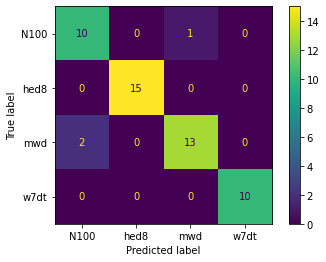

In [ ]:
est = RandomForestClassifier()

estimators = [('lr',LogisticRegression()),
              ('rc',RidgeClassifier()),
              ('et',ExtraTreeClassifier()),
              ('dt',DecisionTreeClassifier()),
              ('rf',RandomForestClassifier()),
              ('ab',AdaBoostClassifier()),
              ('bc',BaggingClassifier())]
stack5 = StackingClassifier(estimators=estimators, final_estimator=est)
stack5.fit(x_train5MinMax, y_train5MinMax)
y_pred5MinMax = stack5.predict(x_val5MinMax)
print(accuracy_score(y_val5MinMax, y_pred5MinMax))
print(classification_report(y_val5MinMax, y_pred5MinMax))

# Plot the confusion matrix using the provided functions.
plot_confusion_matrix(stack5, x_val5MinMax, y_val5MinMax)  
plt.show()  

###Final Test of Nickel Mass Distribution Parameters

In [ ]:
y_testing= stack5.predict(x_test5MinMax)
print(classification_report(y_testing,y_test5MinMax))

              precision    recall  f1-score   support

        N100       0.73      0.80      0.76        10
        hed8       0.87      0.87      0.87        15
         mwd       0.90      0.90      0.90        10
        w7dt       0.88      0.82      0.85        17

    accuracy                           0.85        52
   macro avg       0.84      0.85      0.84        52
weighted avg       0.85      0.85      0.85        52



In [ ]:
y_test11= stack5.predict(test1.reshape(-1,5))
y_test22= stack5.predict(test2.reshape(-1,5))
y_test33= stack5.predict(test3.reshape(-1,5))
print(y_test11,y_test22,y_test33)

['hed8'] ['hed8'] ['hed8']


Although my Model can be used to predict the values with fair efficiency, I would certainly try to implement Boosting Algorithms apart from Ensemble Learning. 

I have not applied Boosting Models to their optimum due to the small dataset here, but it can provide that extra step in accuracy. 